In [50]:
import random
import math
import seaborn as sns
import pandas as pd
import scipy as sp
from scipy.spatial import SphericalVoronoi, ConvexHull
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn.neighbors import NearestNeighbors

In [75]:
def fibonacci_sphere(samples=1):

  points = []
  phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

  for i in range(samples):
    z = 1 - ((i+0.5+random.uniform(-0.5,0.5)) / float(samples)) * 2  # z goes from 1 to -1
    radius = math.sqrt(1 - z * z)  # radius at z

    theta = phi * i+random.uniform(-0.1,0.1)  # golden angle increment

    x = math.cos(theta) * radius
    y = math.sin(theta) * radius

    points.append([x, y, z])

  return points
  

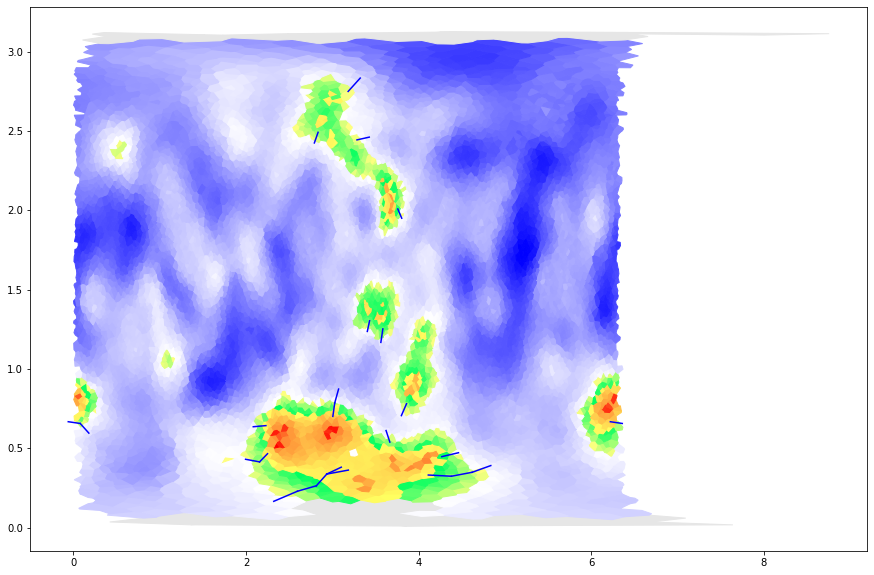

Wall time: 1min 4s


In [130]:
%%time
num=10000
pn=1000
rt=5
nb=20
pts=fibonacci_sphere(num)
pts2d=[]
random.seed(55)
for pt in pts:
  lt=np.arccos(pt[2])
  lg=(2*np.pi-np.arccos(pt[0]/(1-pt[2]**2)**0.5) if pt[1]<0 else np.arccos(pt[0]/(1-pt[2]**2)**0.5))
  pts2d.append([lg,lt])



tri=SphericalVoronoi(pts)
v=[0]*num
for x in range(pn):
  r=random.normalvariate(6000,4000)*np.sign(random.uniform(-51,49))
  z=random.uniform(-1,1)
  t=random.uniform(-np.pi,np.pi)
  x=(1-z**2)**0.5*np.cos(t)
  y=(1-z**2)**0.5*np.sin(t)
  for i in range(num):
    v[i]+=r/(1+50*((pts[i][0]-x)**2+(pts[i][1]-y)**2+(pts[i][2]-z)**2))+random.normalvariate(0,100)
nbrs = NearestNeighbors(n_neighbors=nb, algorithm='ball_tree').fit(pts)
distances, indices = nbrs.kneighbors(pts)
vc=v.copy()
for i in range(num):
  v[i]=sum([vc[j] for j in indices[i]])/nb
for r in range(rt):
  vc=v.copy()
  for i in range(num):
    if v[i]<sorted([vc[j] for j in indices[i]])[-4] or v[i]>sorted([vc[j] for j in indices[i]])[-2]:
      v[i]=0.9*v[i]
vmin=min(min(v),-1)
vmax=max(max(v),1)
fig, ax = plt.subplots(figsize=(15,10))
ver=tri.vertices


# ax = a3.Axes3D(plt.figure())
# for i in range(num):
#   s=tri.regions[i]
#   h=v[i]
#   if h<0:
#     c=[0,0,h/vmin]
#   else:
#     c=[h/vmax,1,0]
#   vtx=[ver[j] for j in s]
#   tr = a3.art3d.Poly3DCollection([vtx])
#   tr.set_color(colors.rgb2hex(c))
#   ax.add_collection3d(tr)

for i in range(num):
  s=tri.regions[i]
  
  h=v[i]
  if h<0 or v[i]<sorted([v[j] for j in indices[i]])[1]:
    if abs(pts2d[i][1]-np.pi/2)<1.5:
#       c=[0,0,1]
      c=[min(1-h/vmin,1),min(1-h/vmin,1),1]
    else:
      c=[0.9,0.9,0.9]
  else:
    if abs(pts2d[i][1]-np.pi/2)<1.4 and h<vmax/4:
      c=[1-4*h/vmax,1,0.5-0.5*h/vmax]
    elif abs(pts2d[i][1]-np.pi/2)<1.4 and h>=vmax/4:
      c=[1,4/3-4/3*h/vmax,0.5-0.5*h/vmax]
    else:
      c=[0.9,0.9,0.9]
  lt=[np.arccos(ver[j][2]) for j in s]
  lg=[np.arccos(ver[j][0]/(1-ver[j][2]**2)**0.5) if ver[j][1]>0 else 2*np.pi-np.arccos(ver[j][0]/(1-ver[j][2]**2)**0.5) for j in s]
  if max(lg)-min(lg)>np.pi:
    lg=[xx+2*np.pi if xx<np.pi else xx for xx in lg]
  ltlg=[[lg[j],lt[j]] for j in range(len(lg))]
  hull=ConvexHull(ltlg)
  hv=hull.vertices
  ax.fill([ltlg[hvi][0] for hvi in hv],[ltlg[hvi][1] for hvi in hv],color=c)
  
used={i:-1 for i in range(num)}
for ir in range(num):
  hp=sorted(indices[ir],key=lambda j:v[j])[-1]
  lp=sorted(indices[ir],key=lambda j:v[j])[0]
  if used[ir]==-1 and hp==ir:
    used[ir]=1
    i=lp
    while v[i]>=0 and used[i]==-1:
      lp=sorted(indices[i],key=lambda j:v[j])[0]
      hp=sorted(indices[i],key=lambda j:v[j])[-1]
      
      if i!=lp and v[i]>=0:
        if pts2d[i][0]-pts2d[lp][0]>np.pi:
          plt.plot([pts2d[i][0],pts2d[lp][0]+np.pi*2],[pts2d[i][1],pts2d[lp][1]],color=[0,0,1])
          plt.plot([pts2d[i][0]-np.pi*2,pts2d[lp][0]],[pts2d[i][1],pts2d[lp][1]],color=[0,0,1])
        elif pts2d[i][0]-pts2d[lp][0]<-np.pi:
          plt.plot([pts2d[i][0],pts2d[lp][0]-np.pi*2],[pts2d[i][1],pts2d[lp][1]],color=[0,0,1])
          plt.plot([pts2d[i][0]+np.pi*2,pts2d[lp][0]],[pts2d[i][1],pts2d[lp][1]],color=[0,0,1])
        else:
          plt.plot([pts2d[i][0],pts2d[lp][0]],[pts2d[i][1],pts2d[lp][1]],color=[0,0,1])
        
        used[i]=1
        i=lp
      else:
        used[i]=1
  
# ax.scatter([j[1] for j in pts2d],[j[0] for j in pts2d])

plt.show()